In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using MKLSparse
using LinearAlgebra
using Flux, DiffEqFlux
using Optim
using CUDA
using CUDA.CUSPARSE
using Plots
using DifferentialEquations: DP5, Tsit5, Vern7, Vern9, BS3
using Random

In [2]:
Random.seed!(1)

TaskLocalRNG()

In [3]:
ω₀ = 2π*5.0
η = -2π*300*1e-3
ω₀ += η
ωlo = ω₀

29.530970943744055

In [4]:
n_levels = 6
bs = FockBasis(n_levels-1)
a = destroy(bs)
ad = create(bs)
id = identityoperator(bs, bs);

In [5]:
H = Hamiltonian((ω₀*(ad*a + 0.5*id) + (η/12.0)*(a + ad)^4))
H += 1.0im*(a - ad);

In [6]:
n_neurons = 8
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 2))
θ = initial_params(ann);

In [7]:
coeffs(params) = t->let b = ann([t], params)
                        [b[1]*cos(ωlo*t) + b[2]*sin(ωlo*t)]
                    end
bcs(params) = 0.1*sum(ann([0.0], params).^2 + ann([4.0], params).^2)
                 
dr = ParametricDrive(Vector{Float64}(θ), coeffs, (0.0, 4.0))

ParametricDrive{Float64}([-0.6983389258384705, -0.6966898441314697, -0.7275957465171814, -0.2461877167224884, -0.7724156975746155, 0.3246825933456421, -0.8149015307426453, 0.2094554305076599, 0.0, 0.0  …  -0.6771047711372375, -0.668251097202301, 0.31138062477111816, 0.6667319536209106, 0.2297903299331665, -0.5286454558372498, -0.03332601860165596, 0.5005793571472168, 0.0, 0.0], coeffs, QuantumOptimalControl.var"#gradients#9"{typeof(coeffs)}(coeffs), 0.0, 4.0)

In [8]:
cost = CostFunction((x,y)->x'*y, bcs)

CostFunction(var"#3#4"(), bcs)

In [9]:
trans = UnitaryTransform([fockstate(bs, 0)=>(fockstate(bs, 0) - 1.0im*fockstate(bs, 1))/√2,
                          fockstate(bs, 1)=>(-1.0im*fockstate(bs, 0) + fockstate(bs, 1))/√2]);

In [10]:
prob = QOCProblem(H, dr, trans, cost);

In [11]:
sol = QuantumOptimalControl.optimize(prob, ADAM(0.002), alg=DP5(), n_iter=1500)

Progress:  35%|██████████████▍                          |  ETA: 0:18:03

-0.02883744984420128
-0.02605576722072339
-0.023901767359898685
-0.02225627244944889
-0.02104413565189911
-0.020180508408915943
-0.019582160184081876
-0.019186690805151674
-0.018951259789404595
-0.018844492152024495
-0.018837303193306232
-0.018896366552772326
-0.018981341496347337
-0.019045336114806077
-0.01904069814377657
-0.01892819400802742
-0.018685108011941398
-0.018309912988633603
-0.01781902661187451
-0.017241692354345972
-0.01661313814239307
-0.015969369894705876
-0.015343003104361375
-0.014761652064348707
-0.014245659583552506
-0.013808345678490042
-0.013455625890249345
-0.013186437235217174
-0.012993636734215275
-0.012864660438448638
-0.012782266264749209
-0.012725591255741409
-0.012671538592489262
-0.012596704393130487
-0.012479777843645345
-0.012303718668768893
-0.0120579269316618
-0.01173918584972189
-0.011351427428259064
-0.010904714600389553
-0.010413697498789676
-0.00989482520497137
-0.00936560910134715
-0.008841296978862101
-0.008334809786147757
-0.007854287064188004
-

Progress:  71%|█████████████████████████████▎           |  ETA: 0:07:57

0.9201201895777689
0.9204763606787296
0.9208929539908289
0.92132513626148
0.9217359375851111
0.9221063229586868
0.9224300143913006
0.9227112984282788
0.9229686710673476
0.9232309048639644
0.923521577949175
0.9238471671494264
0.9242004592030046
0.9245724445180107
0.9249555704164258
0.9253387778060449
0.9257094124054694
0.926062483883501
0.9264000096976637
0.9267221398705148
0.9270236925412108
0.9272996621149775
0.9275493461414097
0.9277760081341241
0.9279858265689942
0.9281889661916933
0.9283986294740973
0.9286249165544989
0.9288699351232326
0.9291297549982299
0.9293981734139763
0.9296676176644335
0.9299314551807465
0.9301883312030753
0.9304422816307997
0.9306989824912026
0.9309621363618985
0.9312320820953551
0.9315060362752384
0.9317785185042418
0.932043170082056
0.932296619876878
0.9325400848433609
0.9327772743127201
0.933012402032106
0.9332491760173904
0.9334895415903329
0.9337330986153713
0.9339780382293759
0.9342231957978004
0.9344687834095484
0.9347149928468907
0.9349614818258477


Progress: 100%|█████████████████████████████████████████| Time: 0:27:43


0.9887396766689356
0.987811921590282
0.9887532241347226
0.9880233474604807
0.9887750110477534
0.9887553477065281
0.9882809914565601
0.9888907027465058
0.9884211053023337
0.9887930535755982
0.9889243194809572
0.9884334142813462
0.9889781025312274
0.9888197441769627
0.9887233396268087
0.9890523856244251
0.9887165787443036
0.9889811693529289
0.9890677568283046
0.9887723805934181
0.9891234799644828
0.9890271801722132
0.9889498616560128
0.9891934687294061
0.9889908882231928
0.9891321885646238
0.9892236855349492
0.9890339199004965
0.9892594427102774
0.9892181382683323
0.9891548577638348
0.989336283197066
0.9892130842147314
0.9892954647948531
0.989374181162672
0.9892564002295332
0.989408567368117
0.9893865715182729
0.9893537560047683
0.9894804917505835
0.9894021488140559
0.989469182325845
0.9895212204497549
0.9894540644731824
0.989563659637192
0.9895426313469812
0.9895443315115142
0.9896276230957876
0.9895748736680386
0.9896415580889344
0.9896643085407341
0.9896390044817579
0.9897197293022234

Solution{Float64}([-1.3489644873750417, -0.3842843830439471, -1.7307235348622116, -0.3918083074942322, -1.8044338972601306, 0.38068893569763285, -1.2729726760041224, 0.5381350467279542, 0.7207024345362302, 1.2632151181855438  …  -1.287234636786292, -1.6776486591259598, 1.4439845185274118, 1.4569590557125423, -0.11357961412820232, -1.6117688808038055, 0.02433111792229316, 1.3633928146666927, 0.21698996315335015, -0.5777903114196701], [-0.02883744984420128, -0.02605576722072339, -0.023901767359898685, -0.02225627244944889, -0.02104413565189911, -0.020180508408915943, -0.019582160184081876, -0.019186690805151674, -0.018951259789404595, -0.018844492152024495  …  0.9940159162684263, 0.9940252681521603, 0.9940339899608055, 0.9940324563387439, 0.994047455906388, 0.9940457538587673, 0.994055661137649, 0.9940621721971377, 0.994063414128939, 0.9940759280532394])

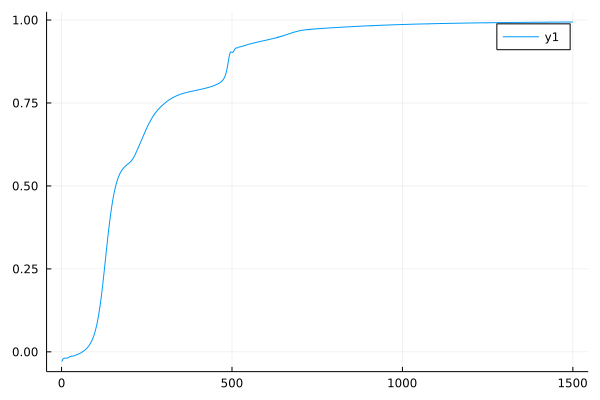

In [17]:
plot(sol.trace)

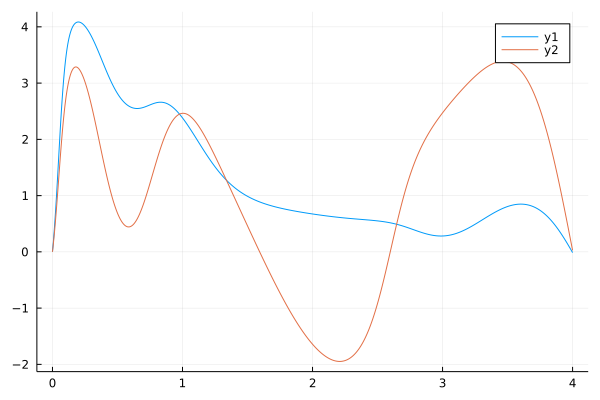

In [13]:
I(t) = ann([t], sol.params)[1]
Q(t) = ann([t], sol.params)[2]

ts = 0.0:0.001:4.0
f = plot(ts, I.(ts))
plot!(f, ts, Q.(ts))